In [1]:
import os
import sys
import pandas as pd

In [2]:
sys.path.append("/home/rocassius/w266_final/scripts/assembly")
sys.path.append("/home/rocassius/w266_final/scripts/modeling")

In [3]:
from document import load_documents
from constant import DOC_GEN_PATH, DOCUMENT, MIN_SESSION, MAX_SESSION, HB_PATH
sessions = list(range(MIN_SESSION, MAX_SESSION+1))

In [4]:
from token_mapping import *
from helper import *
#from embeddings import *

In [17]:
docs_df = load_generic_documents(sessions, DOC_GEN_PATH)

In [18]:
docs_df

,speakerid,lastname,firstname,chamber,state,gender,party,document,session
0,43047111,CONKLING,ROSCOE,S,NY,M,R,I was not going to overlook that fact and comm...,43
1,43048081,BAYARD,THOMAS,S,DE,M,D,Mr. President. of course not for the purpose o...,43
2,43048081,BAYARD,THOMAS,S,DE,M,D,of the case from Oregon of Mr. Stark. Senator ...,43
3,43048081,BAYARD,THOMAS,S,DE,M,D,of timebut the fact of delay. and delay for a ...,43
4,43048081,BAYARD,THOMAS,S,DE,M,D,a record. Many things can contradict a certifi...,43
...,...,...,...,...,...,...,...,...,...
87233,111121510,THOMPSON,MIKE,H,CA,M,D,Madam Speaker. I rise today to honor Mr. Steph...,111
87234,111120060,KING,STEVE,H,IA,M,R,Reclaiming my time and thanking the gentlelady...,111
87235,111120060,KING,STEVE,H,IA,M,R,one single county in America somewhere? They w...,111
87236,111120060,KING,STEVE,H,IA,M,R,applaud every farmer. black or white or Native...,111


In [ ]:
docs_df

In [8]:
docs_df.dtypes

speakerid    object
lastname     object
firstname    object
chamber      object
state        object
gender       object
party        object
document     object
subject      object
session      object
dtype: object

In [19]:
feature_columns = [
 'speakerid',
 'chamber',
 'state',
 'gender',
 'party',
 'session']


In [20]:
import os
import pickle

import tensorflow as tf
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.sequence import pad_sequences


#os.chdir("../assembly/")
from constant import EMBEDDINGS


# constants
GLOVE_DIMS = [50, 100, 200, 300]
EMBEDDING_DIM = GLOVE_DIMS[0]
GLOVE_PATH = os.path.join(EMBEDDINGS, 'glove6B/glove.6B.%dd.csv' % EMBEDDING_DIM)


def fetch_embeddings(embeddings_dim = EMBEDDING_DIM):
    
    path = os.path.join(EMBEDDINGS, 'glove6B/glove.6B.%dd.csv' % embeddings_dim)
    embeddings_index = pd.read_csv(path).to_dict(orient = 'list')
    
    return embeddings_index



def build_embedding_matrix(word_index, embeddings_index, stopwords=[]):
    
    # get the embedding dimension
    embedding_dim = len(embeddings_index['the'])
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None and word not in stopwords:
            # words not found in embedding index and stopwords will be all-zeros.
            embedding_matrix[i] = embedding_vector 
            
    embedding_matrix = embedding_matrix.astype('float16')
    
    return embedding_matrix

In [40]:
def tokenize_pad(documents, tokenizer, max_span_len, padding):
    """Tokenize and pad documents using a tokenizer
    """
    tokenized = tokenizer.texts_to_sequences(documents)
    padded = pad_sequences(tokenized, maxlen=max_span_len, padding=padding)
    
    return padded


def build_tokenizer_dict(document_df, max_span_len = MAX_TOKENS,  padding="post"):
    """Returns a dictionary with useful properties of a tokenizer fit on document_df
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(document_df['document'])
    tokenizer_pad = partial(tokenize_pad, 
                            tokenizer=tokenizer, 
                            max_span_len=max_span_len, 
                            padding=padding)
    
    tokenizer_dict = {
        'tokenizer': tokenizer, 
        'tokenize_pad': tokenizer_pad, 
        'word_index': tokenizer.word_index,
        'max_span_length': max_span_len}
    
    return tokenizer_dict

In [22]:
embedding_index = fetch_embeddings(embeddings_dim=100)

In [26]:
from helper import pickle_object, load_pickled_object

pickle_object(embedding_index, "/home/rocassius/gen-data/tools/embedding_index_100d")

In [27]:
e = load_pickled_object("/home/rocassius/gen-data/tools/embedding_index_100d")

In [23]:
len(embedding_index)

400000

In [45]:
tokenizer_dict = build_tokenizer_dict(docs_df, max_span_len=200, padding="pre")

In [42]:
tokenizer_dict['tokenizer'].texts_to_sequences(["of what once was"])

[[2, 59, 2584, 11]]

In [48]:
tokenizer_dict['tokenize_pad'](["of what once was that was no ever found mipo"])

array([[     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0, 

In [50]:
word_counts = pd.Series(tokenizer_dict['tokenizer'].word_counts).sort_values(ascending=False)

In [51]:
len(word_counts)

2743343

In [58]:
# k = tokenizer_dict['word_index'].keys()


In [52]:
word_counts[:100]

the         57602174
of          30971707
to          25122385
and         20439140
in          17149238
              ...   
am            970612
over          947880
into          928267
american      911731
act           895927
Length: 100, dtype: int64

In [105]:
np.sum(word_counts[word_counts >= 20][500:])

58144436

In [53]:
from preprocess import *
stopwords = (english_stopwords + 
             manual_stopwords + 
             additional_stopwords + 
             us_states_stopwords + 
             name_stopwords)

In [55]:
len(stopwords)

8251

In [66]:
len(word_counts)

2743343

In [82]:
np.sum(word_counts <= 100)

2690182

In [100]:
np.argwhere(np.array(word_counts[:200].index.tolist()) == 'tax')

array([[135]])

In [85]:
common_words = word_counts[word_counts > 50].index.tolist()

In [101]:
too_common_words = word_counts[:100].index.tolist()

In [86]:
" ".join(common_words)

'the of to and in that a is i this it for we have be not on as are by with was from which has will they or our would at an but mr bill been he there all their who if do president these his states my one what no so people were other more can any 000 when had time committee about you its now some than united those congress government should years out state because only under them new such year country us senator very senate house many amendment may federal made am over into american act up upon think law say make me before also program great could first 1 legislation here today most said national must public percent chairman going know just war last every then want s million fact tax take speaker does money believe well where world 2 work support did much way after same get through against being two even like members right shall how need power go him budget department system important service without part question gentleman during own administration come u report good billion let pay hea

In [87]:
common_words_df = pd.DataFrame({'document': [" ".join(common_words)]})
common_tokenizer_dict = build_tokenizer_dict(common_words_df, max_span_len=200, padding="pre")

In [88]:
len(common_tokenizer_dict['word_index'].keys())

74938

In [128]:
def build_embedding_matrix(word_index, embeddings_index, stopwords=[]):
    
    # get the embedding dimension
    embedding_dim = len(embeddings_index['the'])
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None and word not in stopwords:
            # words not found in embedding index and stopwords will be all-zeros.
            embedding_matrix[i] = embedding_vector 
            
    embedding_matrix = embedding_matrix.astype('float16')
    
    return embedding_matrix

In [102]:
common_stopwords = stopwords + too_common_words

In [103]:
len(common_stopwords)

8351

In [104]:
embedding_matrix = build_embedding_matrix(common_tokenizer_dict['word_index'], 
                                          embedding_index, 
                                          stopwords=common_stopwords)

In [113]:
embedding_matrix[common_tokenizer_dict['word_index']['david']]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float16)

In [114]:
embedding_matrix[common_tokenizer_dict['word_index']['tax']]

array([-0.3296  ,  0.257   ,  0.2654  , -0.637   ,  0.741   , -0.1545  ,
       -0.733   ,  0.1326  ,  0.1906  ,  0.1986  , -0.0513  ,  0.4006  ,
       -1.1455  ,  0.03278 ,  0.04358 , -0.4023  ,  0.4812  ,  0.1415  ,
       -0.382   ,  0.6055  ,  0.3267  ,  0.08484 , -0.2452  ,  0.681   ,
       -0.8105  , -0.5137  , -0.2786  , -0.9443  , -1.232   , -0.735   ,
        0.5703  ,  0.7188  , -0.1455  , -0.8164  , -0.4375  ,  0.618   ,
       -0.2764  , -0.61    ,  0.1903  , -0.0644  , -0.1901  , -1.294   ,
        0.5576  ,  0.2769  , -0.4304  , -1.028   , -0.1688  , -0.4976  ,
       -0.549   , -1.043   ,  0.0703  , -0.387   ,  0.012276,  0.829   ,
       -0.562   , -1.567   ,  1.084   , -0.4424  ,  2.514   ,  0.4001  ,
        0.3977  , -0.762   , -0.4307  ,  0.1426  ,  0.896   , -0.564   ,
        0.03323 , -0.2228  ,  0.745   , -1.21    ,  0.192   , -0.3726  ,
       -0.281   ,  0.2734  , -0.6157  , -0.1522  ,  0.107   , -0.315   ,
       -0.97    ,  0.31    ,  1.002   ,  0.277   , 

In [115]:
embedding_matrix[common_tokenizer_dict['word_index']['the']]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float16)

In [117]:
embedding_matrix[common_tokenizer_dict['word_index']['thou']]

array([ 7.280e-01,  1.078e+00,  7.856e-01, -4.846e-01, -1.357e-01,
        8.042e-01, -3.726e-01, -4.487e-01,  6.646e-01,  7.109e-01,
        1.151e-01, -3.054e-01,  7.520e-01,  4.629e-01, -4.678e-01,
       -3.091e-01, -1.373e-01,  8.901e-01, -1.164e+00,  3.030e-01,
        3.054e-01, -4.790e-01, -7.397e-01, -6.250e-01,  7.627e-01,
        8.604e-01, -5.991e-02, -4.566e-03,  5.342e-01, -1.068e+00,
       -1.085e-01, -1.962e-01,  4.824e-01,  1.198e-01, -5.688e-01,
        8.306e-01,  3.823e-01, -9.199e-01, -2.153e-01, -4.229e-01,
        2.905e-01,  1.848e-01, -1.577e-01, -7.710e-01,  7.109e-01,
       -1.104e-02, -7.456e-01, -7.251e-01,  3.616e-01, -8.149e-01,
       -3.738e-01,  1.602e-01, -2.328e-02, -5.034e-01, -9.243e-01,
        2.661e-01,  6.777e-01,  4.272e-01, -2.208e-01, -6.226e-01,
        1.715e-01,  1.035e+00, -1.108e+00, -2.073e-01,  4.128e-01,
        8.804e-01,  6.685e-01,  5.127e-01, -4.326e-01, -5.811e-01,
        4.688e-01, -5.938e-01,  9.780e-01, -5.502e-02,  4.062e

In [118]:
# Save tools to generic tools 
generic_tools_path = "/home/rocassius/gen-data/tools/generic_tools/"

In [131]:
pickle_object(common_tokenizer_dict, os.path.join(generic_tools_path, "tokenizer_dict"))

In [132]:
pickle_object(embedding_matrix, os.path.join(generic_tools_path, "embedding_matrix"))

Make tfidf embedding matrix

In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [122]:
tfidf = TfidfVectorizer(binary=True, token_pattern=r'(?u)\b\w+\b')

In [123]:
import time 
start = time.time()

tfidf.fit(docs_df['document'])
    
end = time.time()
elapsed = end - start 
print(round(elapsed, 3))

681.869


In [133]:
pickle_object(tfidf, os.path.join(generic_tools_path, "tfidf"))

In [126]:
# common_tokenizer_dict['word_index'].values()

In [134]:
# tokenizer index -> word -> tfidf index
index_idf = {i: tfidf.idf_[tfidf.vocabulary_[common_tokenizer_dict['tokenizer'].index_word[i]]]
             for i in common_tokenizer_dict['word_index'].values()}

In [135]:
# check the idf scores
index_idf[common_tokenizer_dict['word_index']['abortion']]

6.599581747605051

In [136]:
index_idf[common_tokenizer_dict['word_index']['the']]

1.0019007014220838

In [137]:
index_idf[common_tokenizer_dict['word_index']['father']]

5.850522199473924

In [138]:
index_idf[common_tokenizer_dict['word_index']['taxation']]

5.580916233594674

In [139]:
index_idf[common_tokenizer_dict['word_index']['relaxation']]

8.645135552721557

In [140]:
index_idf[common_tokenizer_dict['word_index']['fiscal']]

4.149757577701207

In [141]:
index_idf[common_tokenizer_dict['word_index']['implications']]

6.356590874350495

In [142]:
index_idf[common_tokenizer_dict['word_index']['implication']]

7.267559642641548

In [143]:
index_idf[common_tokenizer_dict['word_index']['sting']]

9.31609481830614

In [144]:
index_idf[common_tokenizer_dict['word_index']['disruption']]

7.464674167843723

In [147]:
# put index idf in tokenizer dict
common_tokenizer_dict['index_idf'] = index_idf

In [148]:
import numpy as np

def adjust_embedding(embedding_matrix, tokenizer_dict, c = 1):
    new_embedding_matrix = np.zeros(embedding_matrix.shape)
    
    for i, idf in tokenizer_dict['index_idf'].items():
        new_embedding_matrix[i] = c * idf * embedding_matrix[i]
    
    new_embedding_matrix = new_embedding_matrix.astype(np.float16)
    
    return new_embedding_matrix

In [149]:
idf_embedding_matrix = adjust_embedding(embedding_matrix, common_tokenizer_dict)

In [154]:
norms = np.linalg.norm(idf_embedding_matrix, axis=-1)

In [155]:
import matplotlib.pyplot as plt

(array([2.1423e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 7.0000e+00, 3.9000e+01, 9.5000e+01, 1.7300e+02,
        3.0500e+02, 4.9600e+02, 8.0400e+02, 1.1620e+03, 1.8470e+03,
        2.9030e+03, 3.4530e+03, 3.7320e+03, 4.1770e+03, 4.5750e+03,
        4.5210e+03, 4.4430e+03, 4.1650e+03, 3.6340e+03, 3.1860e+03,
        2.5960e+03, 1.9820e+03, 1.5970e+03, 1.1550e+03, 8.2300e+02,
        5.9100e+02, 3.6200e+02, 2.5600e+02, 1.6600e+02, 8.9000e+01,
        5.5000e+01, 4.8000e+01, 3.1000e+01, 1.7000e+01, 1.0000e+01,
        1.0000e+00, 9.0000e+00, 5.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0.  ,   2.28,   4.56,   6.84,   9.12,  11.4 ,  13.68,  15.96,
         18.23,  20.52,  22.8 ,  25.08,  27.36,  29.64,  31.92,  34.2 ,
         36.47,  38.75,  41.03,  43.3 ,  45.6 ,  47.88,  50.16,  52.44,
         54.72,  57.  ,  59.28,  61.56,  63.84,  66.1 ,  68.4 ,  70.7 ,
         72.94,  75.25,  77.5 

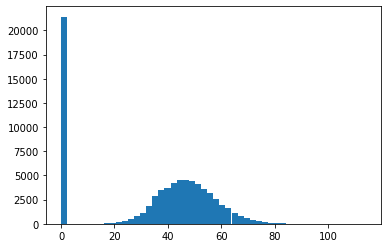

In [160]:
plt.hist(norms, bins=50)

In [159]:
type(idf_embedding_matrix[0,0])

numpy.float16

In [161]:
pickle_object(idf_embedding_matrix, os.path.join(generic_tools_path, "idf_embedding_matrix"))

In [163]:
feature_columns

['speakerid', 'chamber', 'state', 'gender', 'party', 'session']

In [164]:
metadata_dict = build_metadata_dict(docs_df, feature_columns)

In [165]:
pickle_object(metadata_dict, os.path.join(generic_tools_path, "metadata_dict"))